In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset 
from torchvision import datasets, transforms as T
from torchvision.transforms import functional as TF
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import PIL

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
# transformers
def permute(input, permutation):
    return [input[i] for i in permutation]

def flatten(lst):
    return [item for sublst in lst for item in sublst] 
label_id = [range(10), range(10,20), range(20,30), range(30,40), range(40,50), range(50,60)]

class MyRandomRotation(object):
    def __init__(self):
        self.permutations = [
            [0, 1, 2, 3, 4, 5],
            [0, 1, 5, 4, 2, 3],
            [0, 1, 3, 2, 5, 4],
            [0, 1, 4, 5, 3, 2],
        ]

    def __call__(self, sample):
        image, label = sample
        rot = random.randint(0, 3)
        image = TF.rotate(image, rot * 90)
        # label: [squares, circles, up, down, left, right]
        label = torch.tensor(
            permute(label, 
                flatten(permute(
                    label_id,
                    self.permutations[rot]
                ))
            )
        )
        return (image, label)


class MyRandomFlip(object):
    def __init__(self):
        self.permutations = [
            [0, 1, 2, 3, 4, 5],
            [0, 1, 2, 3, 5, 4],
        ]

    def __call__(self, sample):
        image, label = sample
        flip = random.randint(0, 1)
        if flip == 1:
            image = TF.hflip(image)
        # label: [squares, circles, up, down, left, right]
        label = torch.tensor(
            permute(label, 
                flatten(permute(
                    label_id,
                    self.permutations[flip]
                ))
            )
        )
        return (image, label)

In [32]:
loader = T.Compose([
    T.ToTensor()])
transform = T.Compose([
    MyRandomRotation(),
    MyRandomFlip()
])

# transform = None

class CountingDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.loc[index, 'name']

        squares_num = self.df.loc[index, "squares"]
        circles_num = self.df.loc[index, "circles"]
        up_num = self.df.loc[index, "up"]
        down_num = self.df.loc[index, "down"]
        right_num = self.df.loc[index, "right"]
        left_num = self.df.loc[index, "left"]

        squares = [0] * 10
        squares[squares_num] = 1
        circles = [0] * 10
        circles[circles_num] = 1
        up = [0] * 10
        up[up_num] = 1
        down = [0] * 10
        down[down_num] = 1
        left = [0] * 10
        left[left_num] = 1
        right = [0] * 10
        right[right_num] = 1

        label = torch.tensor(squares + circles + up + down + left + right)
        image = PIL.Image.open(os.path.join(self.images_folder, filename))


        if self.transform is not None:
            image, label = self.transform((image, label))

        image = loader(image)[0].unsqueeze(0)

        return image.to(device, torch.float), label


In [33]:
images_folder = './data'
csv_path = './data/labels.csv'

dataset_size = 10000
dev_dataset_size = 1000
val_dataset_size = 1000
train_dataset_size = dataset_size - dev_dataset_size - val_dataset_size

dataset = CountingDataset(csv_path, images_folder, transform)
train_dataset = Subset(dataset, range(train_dataset_size))
dev_dataset = Subset(dataset, range(train_dataset_size, train_dataset_size + dev_dataset_size))
val_dataset = Subset(dataset, range(train_dataset_size + dev_dataset_size, dataset_size))

tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
-----------------
tensor([6, 0, 4, 0, 0, 0])


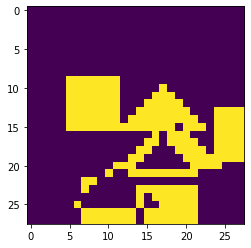

In [34]:
i = 1
d = val_dataset[i]
print(d[1].reshape((6, 10)))
print('-----------------')
plt.imshow(d[0].cpu().numpy().reshape((28, 28)))
# label: [squares, circles, up, down, left, right]
print(d[1].reshape((6, 10)).argmax(dim=1))

In [35]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3, stride=1),
            nn.BatchNorm2d(48),
            nn.SiLU()
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(48, 96, kernel_size=3, stride=1),
            nn.BatchNorm2d(96),
            nn.SiLU(),
            nn.MaxPool2d(2)
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(96, 192, kernel_size=3, stride=1),
            nn.BatchNorm2d(192),
            nn.SiLU(),
            )
        self.layer4 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, stride=1),
            nn.BatchNorm2d(384),
            nn.SiLU(),
            nn.MaxPool2d(2)
            )

        self.drop_out_con = nn.Dropout(0.01)
        self.drop_out_fc = nn.Dropout(0.25)

        self.fc1 = nn.Sequential(
            nn.Linear(4 * 4 * 384, 196),
            nn.BatchNorm1d(196),
            nn.SiLU())
       
        self.fc2 = nn.Sequential(
            nn.Linear(196, 60))
    def forward(self, x):
        x = self.layer1(x)
        x = self.drop_out_con(x)
        x = self.layer2(x)
        x = self.drop_out_con(x)
        x = self.layer3(x)
        x = self.drop_out_con(x)
        x = self.layer4(x)

        x = x.view(x.size(0), -1)

        x = self.drop_out_fc(x)
        x = self.fc1(x)
        x = self.drop_out_fc(x)
        x = self.fc2(x)
        x = x.reshape((-1, 6, 10)).softmax(dim=2).reshape((-1, 60))
        return x

In [36]:
batch_size = 16

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}

train_generator = DataLoader(train_dataset, **params)
dev_generator = DataLoader(dev_dataset, **params)
val_generator = DataLoader(val_dataset, **params)

In [40]:
learning_rate = 0.001
weight_decay = 0

model = ConvNet()

def my_counting_loss(output, target, log=False):
    batch_size = output.size()[0]

    shapes_quantities = torch.tensor([6 * list(range(10))]).repeat(batch_size, 1).to(device)

    target_shapes_quantity = target.reshape((batch_size, 6, 10)).argmax(dim=2).repeat_interleave(10, dim=1).to(device)

    part_loss = output * (target_shapes_quantity - shapes_quantities) ** 2

    loss = part_loss.sum((0,1))
    return loss / batch_size

def my_counting_loss_abs(output, target):
    batch_size = output.size()[0]

    shapes_quantities = torch.tensor([6 * list(range(10))]).repeat(batch_size, 1).to(device)

    target_shapes_quantity = target.reshape((batch_size, 6, 10)).argmax(dim=2).repeat_interleave(10, dim=1).to(device)

    part_loss = (output * (target_shapes_quantity - shapes_quantities)).abs()
    loss = part_loss.sum((0,1))
    return loss / batch_size

optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8, dampening=0, weight_decay=weight_decay, nesterov=True)
criterion = my_counting_loss

if torch.cuda.is_available():
    model = model.cuda()

# print(model)

In [41]:
def correct_num(predicted, target, log=False):

    maxPred = predicted.reshape((-1, 6, 10)).argmax(dim=2)
    maxTarg = target.reshape((-1, 6, 10)).argmax(dim=2)
    if log:
        print('---------------------------------------')
        print('pred:', maxPred[0])
        print('targ:', maxTarg[0])
        print('loss:', my_counting_loss(predicted[0].resize(1,60), target[0].resize(1,60)).item())
        print('---------------------------------------')
    return (maxPred == maxTarg).prod(1).sum()

In [42]:
round_num = 6
def train(max_epochs):

    dev_losses = []
    dev_accs = []
    train_losses = []
    train_accs = []

    for epoch in range(max_epochs):

        # Training
        train_loss = 0
        train_correct = 0
        model.train()
        for local_batch, local_labels in train_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            batch_size = local_batch.size()[0]

            optimizer.zero_grad()

            predicted_labels = model(local_batch)
            
            train_correct = train_correct + correct_num(predicted_labels, local_labels)

            loss = criterion(predicted_labels.to(torch.float32), local_labels.to(torch.float32))
            
            loss.backward()
            optimizer.step()
            train_loss = train_loss + batch_size * loss 

        train_acc = train_correct / train_dataset_size
        train_loss = train_loss / train_dataset_size
        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())

        # Validation
        dev_loss = 0
        dev_correct = 0
        model.eval()
        with torch.set_grad_enabled(False):
            for local_batch, local_labels in dev_generator:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                batch_size = local_batch.size()[0]

                predicted_labels = model(local_batch).to(torch.float32)

                first = (dev_loss == 0)

                dev_correct = dev_correct + correct_num(predicted_labels, local_labels, first) 
                dev_loss = dev_loss + batch_size * criterion(predicted_labels.to(torch.float32), local_labels.to(torch.float32))

        dev_acc = dev_correct / dev_dataset_size
        dev_loss = dev_loss / dev_dataset_size
        dev_losses.append(dev_loss.item())
        dev_accs.append(dev_acc.item())
        print('Epoch : ',epoch+1, '\t',
            'train_loss :', round(train_loss.item(), round_num),
            'train_acc:', round(train_acc.item(), round_num),
            'dev_loss :', round(dev_loss.item(), round_num),
            'dev_acc:', round(dev_acc.item(), round_num))
    return dev_losses, dev_accs, train_losses, train_accs


In [43]:
max_epochs = 250
print('TRAINING STARTED')
dev_losses, dev_accs, train_losses, train_accs = train(max_epochs)

_acc: 0.02
---------------------------------------
pred: tensor([0, 0, 0, 4, 0, 5], device='cuda:0')
targ: tensor([0, 0, 0, 6, 0, 4], device='cuda:0')
loss: 5.0
---------------------------------------
Epoch :  182 	 train_loss : 7.361433 train_acc: 0.016375 dev_loss : 7.062309 dev_acc: 0.021
---------------------------------------
pred: tensor([0, 4, 0, 0, 2, 0], device='cuda:0')
targ: tensor([0, 8, 0, 0, 2, 0], device='cuda:0')
loss: 16.808591842651367
---------------------------------------
Epoch :  183 	 train_loss : 7.277048 train_acc: 0.016125 dev_loss : 6.94306 dev_acc: 0.015
---------------------------------------
pred: tensor([0, 4, 0, 0, 0, 5], device='cuda:0')
targ: tensor([0, 3, 0, 0, 0, 7], device='cuda:0')
loss: 5.074854373931885
---------------------------------------
Epoch :  184 	 train_loss : 7.319663 train_acc: 0.018625 dev_loss : 7.088916 dev_acc: 0.022
---------------------------------------
pred: tensor([0, 0, 5, 4, 0, 0], device='cuda:0')
targ: tensor([0, 0, 5, 5,

In [44]:
# validation
val_correct = 0
val_loss = 0
model.eval()
with torch.set_grad_enabled(False):
    for local_batch, local_labels in val_generator:
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        batch_size = local_batch.size()[0]

        predicted_labels = model(local_batch).to(torch.float32)
        
        val_correct = val_correct + correct_num(predicted_labels, local_labels, True) 

        val_loss = val_loss + batch_size * criterion(predicted_labels.to(torch.float32), local_labels.to(torch.float32))
val_acc = val_correct / val_dataset_size
val_loss = val_loss / val_dataset_size

print('validation loss: ', val_loss.item(), 'validation accuracy: ', val_acc.item())


---------------------------------------
pred: tensor([0, 0, 3, 0, 0, 5], device='cuda:0')
targ: tensor([0, 0, 3, 0, 0, 7], device='cuda:0')
loss: 4.000000476837158
---------------------------------------
---------------------------------------
pred: tensor([0, 4, 4, 0, 0, 0], device='cuda:0')
targ: tensor([0, 6, 4, 0, 0, 0], device='cuda:0')
loss: 4.0000104904174805
---------------------------------------
---------------------------------------
pred: tensor([0, 4, 0, 0, 0, 4], device='cuda:0')
targ: tensor([0, 7, 0, 0, 0, 3], device='cuda:0')
loss: 9.842000007629395
---------------------------------------
---------------------------------------
pred: tensor([0, 0, 0, 0, 4, 2], device='cuda:0')
targ: tensor([0, 0, 0, 0, 6, 4], device='cuda:0')
loss: 7.860925197601318
---------------------------------------
---------------------------------------
pred: tensor([0, 4, 0, 0, 0, 5], device='cuda:0')
targ: tensor([0, 4, 0, 0, 0, 6], device='cuda:0')
loss: 1.0001003742218018
------------------

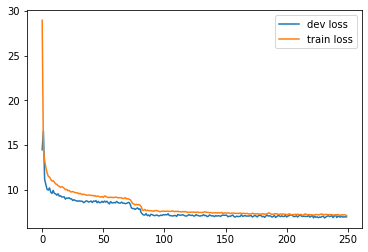

In [45]:
plt.plot(dev_losses)
plt.plot(train_losses)
plt.legend(['dev loss', 'train loss'])
plt.show()

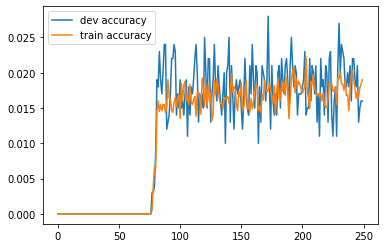

In [46]:
plt.plot(dev_accs)
plt.plot(train_accs)
plt.legend(['dev accuracy', 'train accuracy'])
plt.show()

<ipython-input-47-04c3967bac57>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


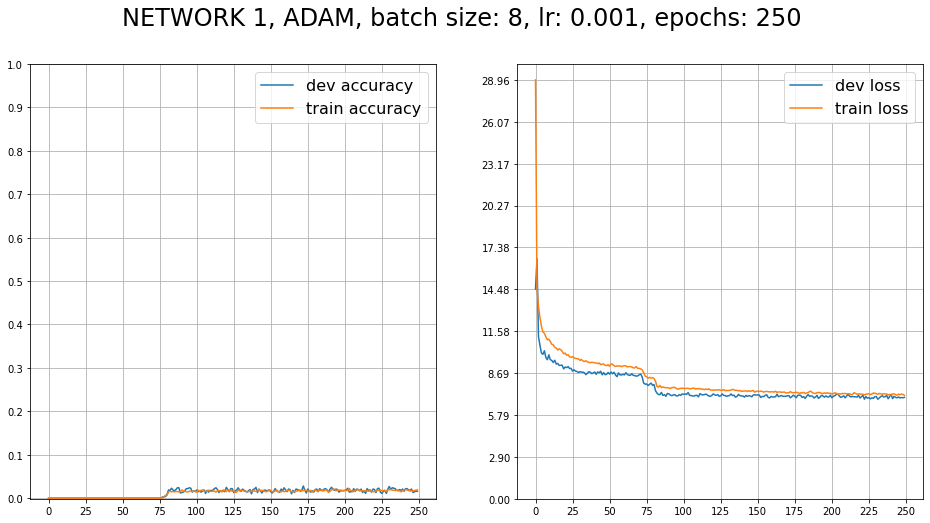

In [47]:
max_loss = max(max(dev_losses), max(train_losses))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f'NETWORK 2, ADAM, batch size: {batch_size}, epochs: {max_epochs}', fontsize=24)
ax1.plot(dev_accs)
ax1.plot(train_accs)
ax1.legend(['dev accuracy', 'train accuracy'], fontsize=16)
ax1.set_xticks(np.arange(0, max_epochs + 1, max_epochs/10))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.grid()

ax2.plot(dev_losses)
ax2.plot(train_losses)
ax2.legend(['dev loss', 'train loss'], fontsize=16)
ax2.set_xticks(np.arange(0, max_epochs + 1, max_epochs/10))
ax2.set_yticks(np.arange(0, max_loss + 0.01, max_loss/10))
ax2.grid()

fig.show()